In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
# Parameters for tunning

BASE_IMG_FOLDER = './VC_2425_Project_public/images/'

# Parameters for the image processing
SHOW_DEBUG_IMGS = "NONE" # ["LINES", "WARP", "ALL", "NONE"]
CORNER_HORSE_TEMPLATE_PATH = "./cornerHorse_templates/"
SAVE_DEBUG_IMGS = False

In [ ]:
# Load the images for the corner horses and store them in a list
CORNER_HORSES_TEMPLATES = []
for filename in os.listdir(CORNER_HORSE_TEMPLATE_PATH):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(CORNER_HORSE_TEMPLATE_PATH, filename))
        CORNER_HORSES_TEMPLATES.append(img)
    else:
        continue

In [ ]:
def show_original_and_gray(image_path):
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Wood removal by color thresholding (targeting brown/wooden colors)
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    
    # Define range for brown/wooden colors in HSV
    lower_brown = np.array([2, 11, 11])
    upper_brown = np.array([60, 255, 255]) 
    
    # Create mask for wood
    wood_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    
    # Invert the mask to keep non-wood parts
    wood_mask_inv = cv2.bitwise_not(wood_mask)
    
    # Apply the mask to the original image
    no_wood_img = cv2.bitwise_and(original_img, original_img, mask=wood_mask_inv)
    
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(no_wood_img, cv2.COLOR_BGR2GRAY)

    # Display images to show the process
    if SHOW_DEBUG_IMGS == "ALL":
        plt.figure(figsize=(10, 5))

        # Original image - left
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title('Original RGB Image')

        # Final grayscale image - right
        plt.subplot(1, 2, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
        plt.title('Without Wood Grayscale Image')

        plt.tight_layout()
        plt.show()

    return original_img, gray_img

In [ ]:
def preprocess_image(gray_img, blur_kernel_size=17, intensity_factor=1.3, laplacian_kernel_size=3):
    blurred = cv2.GaussianBlur(gray_img, (blur_kernel_size, blur_kernel_size), 0)
    adjusted_img = cv2.convertScaleAbs(blurred, alpha=intensity_factor, beta=0)

    # Morphological opening to remove small details like pieces
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opened = cv2.morphologyEx(adjusted_img, cv2.MORPH_OPEN, kernel)

    laplacian = cv2.Laplacian(opened, cv2.CV_64F, ksize=laplacian_kernel_size)
    laplacian = cv2.convertScaleAbs(laplacian)

    # OTSU + optional manual offset to suppress weak edges
    otsu_thresh_val, _ = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary_img = cv2.threshold(laplacian, otsu_thresh_val + 20, 255, cv2.THRESH_BINARY)

    return binary_img

In [ ]:
def detect_lines(binary_img, min_line_length=50, max_line_gap=50):
    # Canny edge detection with lower threshold
    canny_image = cv2.Canny(binary_img, 50, 200)  # Tuning thresholds to capture better edges

    # Use dilation to reinforce edges
    kernel = np.ones((13, 13), np.uint8)
    dilation_image = cv2.dilate(canny_image, kernel, iterations=1)
    
    # Hough Lines transform for line detection
    lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Create an image to store the detected lines
    black_image = np.zeros_like(dilation_image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
    return black_image

In [ ]:
def remove_noise_components(line_img, min_area=1000, keep_largest=True):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(line_img, connectivity=8)
    
    # Create a black image to store the final result
    final_image = np.zeros_like(line_img)
    
    if keep_largest:
        # Get the areas of all components (ignoring the background)
        areas = stats[1:, cv2.CC_STAT_AREA]
        
        # Find the label of the largest component
        max_label = 1 + np.argmax(areas)
        
        # Keep only the largest component
        final_image[labels == max_label] = 255
    else:
        # If not keeping only the largest component, keep components above the min_area threshold
        for label in range(1, num_labels):
            area = stats[label, cv2.CC_STAT_AREA]
            if area >= min_area:
                final_image[labels == label] = 255

    if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES"):
        plt.subplot(1, 3, 1)
        plt.title("Only Board Lines (Filtered)", fontsize=12)
        plt.imshow(final_image, cmap="gray")
        plt.axis('off')

    return final_image


In [ ]:
def find_chessboard_contour(line_img):
    contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    if contours:
        return contours[0]
    return None

In [ ]:
def order_corners(corners):
    sorted_by_y = sorted(corners, key=lambda p: p[1])
    top_two = sorted(sorted_by_y[:2], key=lambda p: p[0])
    bottom_two = sorted(sorted_by_y[2:], key=lambda p: p[0])
    return np.array([top_two[0], top_two[1], bottom_two[0], bottom_two[1]], dtype="float32")

In [ ]:
def warp_chessboard(gray_img, original_img, contour, board_size=800):
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx_corners = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx_corners) == 4:
        corners = np.squeeze(approx_corners)
        ordered_corners = order_corners(corners)
        dst_corners = np.array([
            [0, 0], [board_size - 1, 0],
            [0, board_size - 1], [board_size - 1, board_size - 1]
        ], dtype="float32")
        matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
        warped_board = cv2.warpPerspective(gray_img, matrix, (board_size, board_size))
        
        # Also warp the original RGB image
        warped_original = cv2.warpPerspective(original_img, matrix, (board_size, board_size))
        warped_original_rgb = cv2.cvtColor(warped_original, cv2.COLOR_BGR2RGB)
        
        if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES" or SHOW_DEBUG_IMGS == "WARP"):
            plt.subplot(1, 3, 2)
            plt.title("Warped Chessboard (Grayscale)", fontsize=12)
            plt.imshow(warped_board, cmap="gray")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Warped Chessboard (Original)", fontsize=12)
            plt.imshow(warped_original_rgb)
            plt.axis('off')
            
        return warped_board, warped_original_rgb
    else:
        print("Error: Did not find exactly 4 corners!")
        return None

In [ ]:
def process_chessboard_image(image_path):
    original_img, gray_img = show_original_and_gray(image_path)
    otsu_binary = preprocess_image(gray_img)
    line_img = detect_lines(otsu_binary)
    clean_line_img = remove_noise_components(line_img)
    contour = find_chessboard_contour(clean_line_img)
    if contour is not None:
        return warp_chessboard(gray_img, original_img, contour)
    else:
        print("Chessboard contour not found!")
        return None

In [145]:
def detect_squares_by_grid_intersections(warped_img, debug=True):
    gray = warped_img if len(warped_img.shape) == 2 else cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=20)

    if lines is None:
        print("No lines detected.")
        return []

    horizontals, verticals = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if abs(angle) < 15:
            horizontals.append(line[0])
        elif abs(angle - 90) < 15 or abs(angle + 90) < 15:
            verticals.append(line[0])

    if debug:
        line_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for x1, y1, x2, y2 in horizontals:
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
        for x1, y1, x2, y2 in verticals:
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        plt.imshow(line_img)
        plt.title("Detected Grid Lines")
        plt.axis("off")
        plt.show()

    # Convert lines to equations and find intersections
    def line_to_params(x1, y1, x2, y2):
        A = y2 - y1
        B = x1 - x2
        C = A * x1 + B * y1
        return A, B, C

    def intersection(l1, l2):
        A1, B1, C1 = line_to_params(*l1)
        A2, B2, C2 = line_to_params(*l2)
        det = A1 * B2 - A2 * B1
        if det == 0:
            return None
        x = (B2 * C1 - B1 * C2) / det
        y = (A1 * C2 - A2 * C1) / det
        return int(x), int(y)

    points = []
    for h in horizontals:
        for v in verticals:
            pt = intersection(h, v)
            if pt:
                points.append(pt)

    # Filter duplicates / sort points into grid
    def dedupe_points(pts, dist_thresh=10):
        filtered = []
        for pt in pts:
            if all(np.linalg.norm(np.array(pt) - np.array(f)) > dist_thresh for f in filtered):
                filtered.append(pt)
        return filtered

    points = dedupe_points(points)
    if len(points) < 81:
        print(f"Only found {len(points)} grid points — not enough for full chessboard.")
        return []

    # Sort points first vertically, then horizontally within rows
    points = sorted(points, key=lambda p: (p[1], p[0]))  # sort by y, then x

    # Sort by y, then cluster into rows using y-coordinate proximity
    points = np.array(points)
    points = points[np.argsort(points[:, 1])]  # sort by y

    # Group rows by y proximity
    rows = []
    current_row = [points[0]]
    for pt in points[1:]:
        if abs(pt[1] - current_row[-1][1]) < 20:
            current_row.append(pt)
        else:
            rows.append(current_row)
            current_row = [pt]
    rows.append(current_row)

    # Sort each row by x and make sure we only keep rows with exactly 9 points
    rows = [sorted(row, key=lambda p: p[0]) for row in rows if len(row) >= 9]
    rows = rows[:9]  # Keep only the top 9 if extras sneak in

    if len(rows) < 9 or any(len(row) < 9 for row in rows):
        print("Could not form a 9x9 grid from intersections.")
        return []

    # Build squares from 4 adjacent points
    square_contours = []
    for i in range(8):
        for j in range(8):
            pt1 = rows[i][j]
            pt2 = rows[i][j+1]
            pt3 = rows[i+1][j+1]
            pt4 = rows[i+1][j]
            square = np.array([pt1, pt2, pt3, pt4])
            square_contours.append(square)

    if debug:
        grid_vis = warped_img.copy()
        if len(grid_vis.shape) == 2:
            grid_vis = cv2.cvtColor(grid_vis, cv2.COLOR_GRAY2BGR)
        for pt in points:
            cv2.circle(grid_vis, tuple(pt), 5, (0, 0, 255), -1)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(grid_vis, cv2.COLOR_BGR2RGB))
        plt.title("All Grid Points (Red)")
        plt.axis("off")
        plt.show()

    return square_contours

In [ ]:
def find_horse_template_matching(image_rgb, image_name=None):
    img_rgb = image_rgb.copy()
    height, width = img_rgb.shape[:2]
    
    best_match_val = -np.inf
    best_match_loc = None
    best_template_shape = None
    best_template_index = None

    for idx, template_rgb in enumerate(CORNER_HORSES_TEMPLATES):
        if template_rgb is None:
            print(f"Template at index {idx} is None.")
            continue

        h, w = template_rgb.shape[:2]
        
        # Template matching
        res = cv2.matchTemplate(img_rgb, template_rgb, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        if max_val > best_match_val:
            best_match_val = max_val
            best_match_loc = max_loc
            best_template_shape = (h, w)
            best_template_index = idx

    print(f"Best match index: {best_template_index} with score {best_match_val:.2f}")
    if best_match_val >= 0.65:
        top_left = best_match_loc
        h, w = best_template_shape
        bottom_right = (top_left[0] + w, top_left[1] + h)

        # Draw match rectangle
        cv2.rectangle(img_rgb, top_left, bottom_right, (0, 255, 0), 2)

        # Center of match
        center_x = top_left[0] + w // 2
        center_y = top_left[1] + h // 2

        # Determine closest corner
        corners = [
            ("top-left", (0, 0)),
            ("top-right", (width, 0)),
            ("bottom-left", (0, height)),
            ("bottom-right", (width, height))
        ]
        
        closest_corner = min(corners, key=lambda c: 
            np.sqrt((center_x - c[1][0])**2 + (center_y - c[1][1])**2))

        # Print image name and closest corner
        if image_name:
            print(f"{image_name}: {closest_corner[0]}")
        else:
            print(f"Closest corner: {closest_corner[0]}")
            
        return closest_corner[0]
    else:
        if image_name:
            print(f"{image_name}: No good match found.")
        else:
            print("No good match found.")
        return None

Processing G000_IMG062.jpg


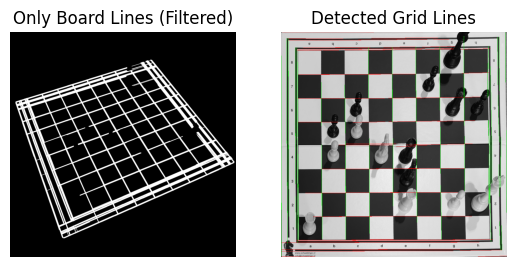

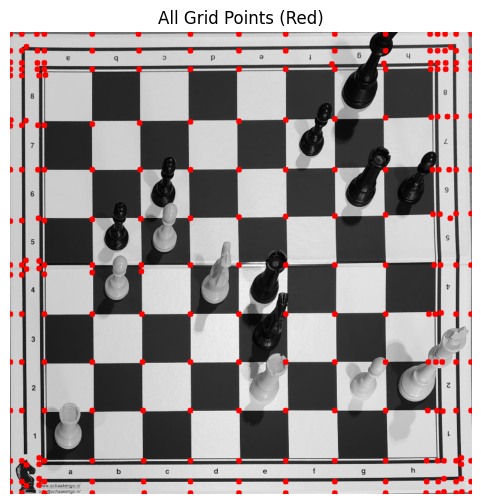

<Figure size 1500x700 with 0 Axes>

Processing G000_IMG087.jpg


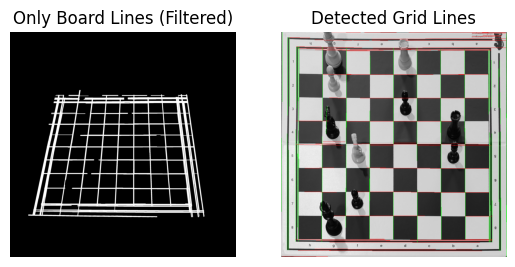

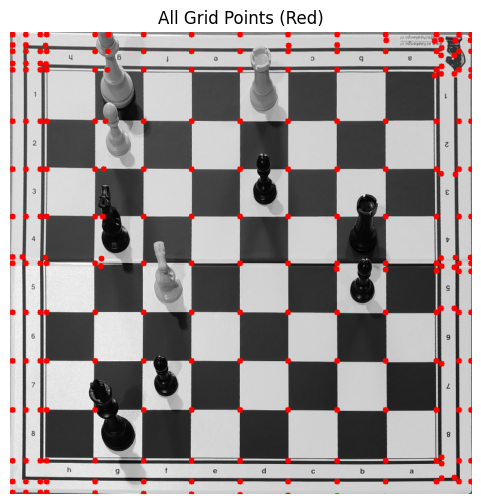

<Figure size 1500x700 with 0 Axes>

Processing G000_IMG102.jpg


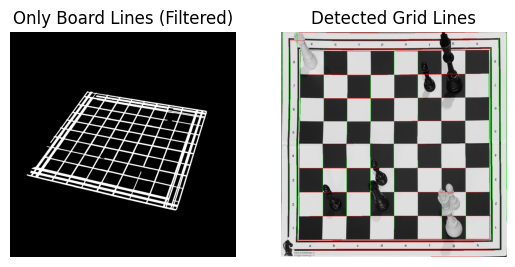

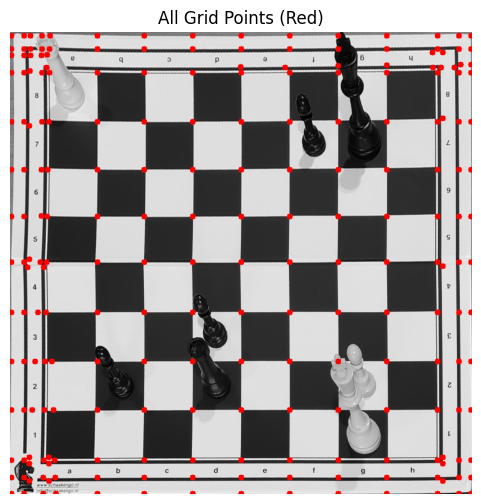

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG048.jpg


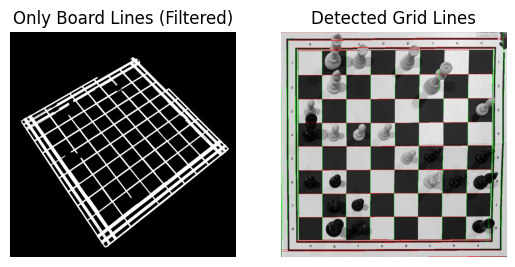

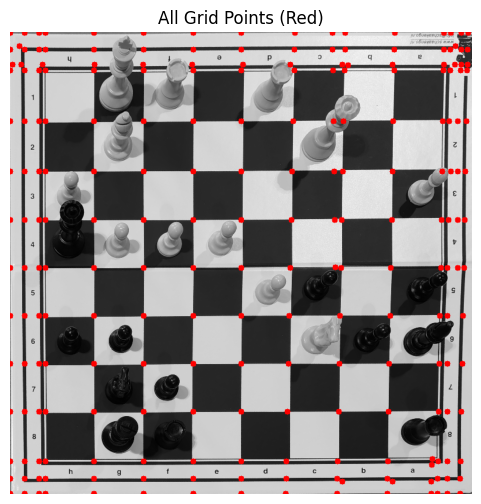

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG086.jpg


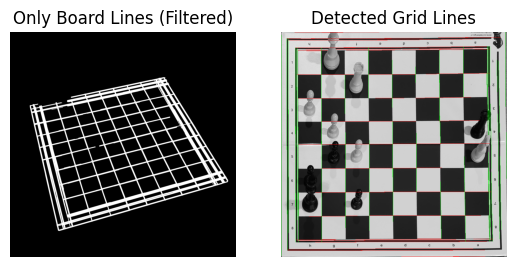

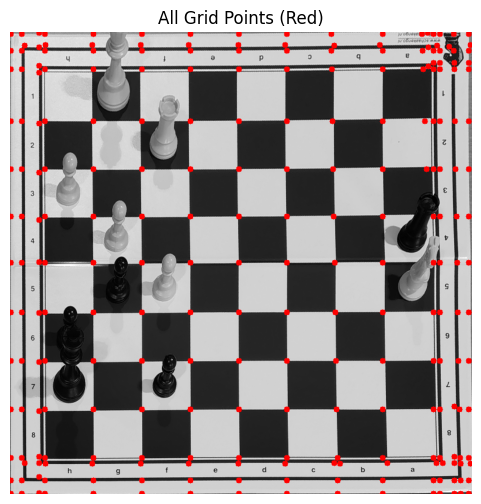

<Figure size 1500x700 with 0 Axes>

Processing G006_IMG119.jpg


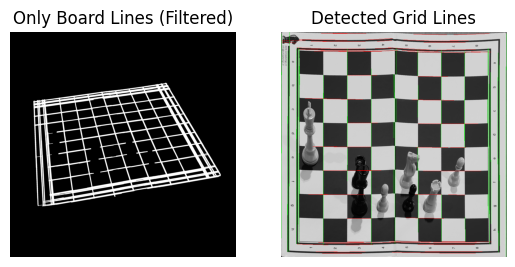

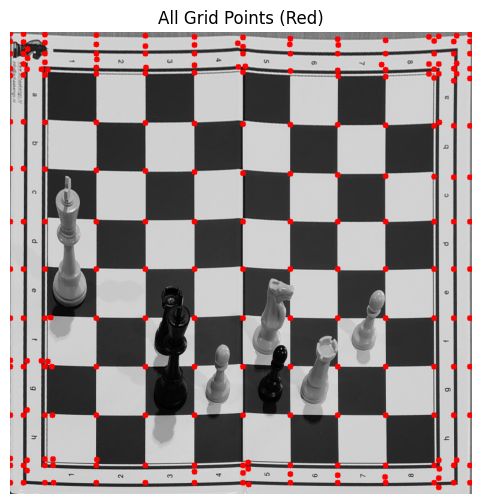

<Figure size 1500x700 with 0 Axes>

Processing G019_IMG082.jpg


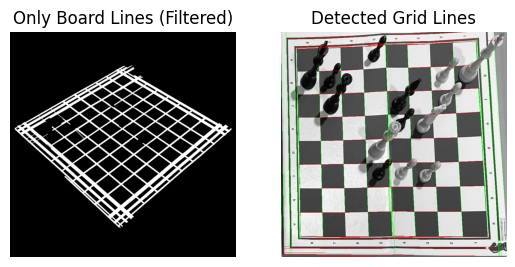

KeyboardInterrupt: 

In [ ]:
# Create output directory if it doesn't exist
output_dir = './chessboard_outputs/'
os.makedirs(output_dir, exist_ok=True)

# Process all images in the images folder
image_files = [os.path.join(BASE_IMG_FOLDER, f) for f in os.listdir(BASE_IMG_FOLDER) if f.endswith(('.jpg', '.png', '.jpeg'))]

# # Define specific image files to process
# image_filenames_failed = [
# "G000_IMG102.jpg",
# "G038_IMG074.jpg",
# "G047_IMG102.jpg",
# "G078_IMG092.jpg"
# ]

# # Create full paths for each image file
# image_files = [os.path.join(BASE_IMG_FOLDER, filename) for filename in image_filenames_failed]

# Process each image
failed_images = []
for image_path in image_files:
    filename = os.path.basename(image_path)
    print(f"Processing {filename}")

    if (SHOW_DEBUG_IMGS != "NONE"):
        plt.figure(figsize=(16, 8))
    warped, warped_original_rgb = process_chessboard_image(image_path)
    closest_corner = find_horse_template_matching(warped_original_rgb, filename)
    
    if warped is None:
        failed_images.append(filename)
    
    if (SHOW_DEBUG_IMGS != "NONE"):
        plt.tight_layout(pad=3.0)
        # Save the figure with subplots
        subplot_path = os.path.join(output_dir, f"subplots_{filename.split('.')[0]}.png")
        if SAVE_DEBUG_IMGS:
            plt.savefig(subplot_path, dpi=300, bbox_inches='tight')
        print(f"Saved subplots to {subplot_path}")
        plt.show()

print("\nImages where chessboard detection failed:")
for failed_image in failed_images:
    print(failed_image)

print(f"\nSuccessfully processed {len(image_files) - len(failed_images)}/{len(image_files)} images")
print(f"Subplot images saved to: {os.path.abspath(output_dir)}")